<img src="https://snipboard.io/Kx6OAi.jpg">

# Session 2. Intro to Dask
<div style="margin-top: -10px; padding: 5px; line-height: 20px;"><img src="https://snipboard.io/v5q47G.jpg" style="width: 35px; float: left; margin-right: 10px;"> Author:  <a href="http://www.linkedin.com/in/davidyerrington">David Yerrington</a>, Data Scientist<br>San Francisco, CA</div>

## Learning Objectives

- Understand how graphs represent tasks with dependencies.
- Assess trade-offs between various Dask data types.
- Examining tasks in real-time using the Dask dashboard.

### Prerequisite Knowledge
- Basic Pandas 
  - Difference between Series vs Dataframe
  - Bitmasks, query function, selecting data
  - Aggregations

## Environment Setup

We will first review some basic points to setup Python and the environment to start in [the setup guide](../environment.md).


## Imports

In [ ]:
from dask.distributed import Client
from dask import delayed
import dask.bag as db
import dask.array as da
import time, json, dask

## If you're having problems with excessive warnings, uncomment this import
# import sys, warnings
# warnings.simplefilter('ignore')
# warnings.filterwarnings('ignore')

### Question: What is the most difficult aspect to undertand of Dask parallel computing so far?

## 1. The Obligatory DAG Examples

### Example 1: Basic Methods

This example is ubiquitous but a good place to start.

In [ ]:
## Setup a basic client first
from dask.distributed import Client

client = Client()
client

In [ ]:
def inc(x):
    time.sleep(1)
    return x + 1

def add(a, b, c, d):
    time.sleep(1)
    return a + b + c + d

## How long do we expect the next cell to run for?

This is a basic example.

In [ ]:
%%time

a = inc(10)
b = inc(20)
c = inc(30)
d = inc(40)
e = add(a, b, c, d)
e

###  Basic Methods - Parallalized!

_Note the time._

> If you have your own code that runs in some sort of logical order, you can use the "delayed" wrapper function (also works as a decorator).



In [ ]:
%%time


### What is happenning?

> **GraphViz Problems?**
>
> If you are having trouble with the GraphViz executable, double check the [the setup guide](../environment.md).  Double check that your Graphviz executable is installed in your current notebook environment:  https://graphviz.org/download/
>
> GraphViz is nice to have but not essential for our session.  Notebooks will be updated with these visuals and checked in post-session.


- The flow of the DAG happens from the bottom up.
- The order of tasks is represented in the order they occur.
- Names of functions are drawn over the task objects.

### Example 2: Iteration

In [ ]:
%%time 

data = range(1, 5)

results = []
for i in data:
    x = inc(i)
    results.append(x)

total = sum(results)
total

### Iteration - Parallelized!

In [ ]:
%%time 


In [ ]:
# Visualize graph


### Example 2: Iteration + Control Flows

In [ ]:
%%time 

data = range(1, 10)

def double(x):
    return x * 2

results = []
# We will write this code from here

In [ ]:
# Visualize

## 2. Collection: Bag

The Bag collection type (also known as a multiset) is a generic, distributed sequential type that works like a `list`.  The added feature is that you can specify how many partitions it will hold.  The `npartitions` parameter is used to control the granularity of parallelism.

>  If you don't specify number of partitions, the default is ~100. 

![](https://snipboard.io/ezZcF4.jpg)

### Properties
- Bags are immutable!
- Bags are parititoned.

### Common Uses

The bag `db` is schema-less, so it's flexible.  Working with lower-level tasks is its primary use case.  The main methods of transformation and use are provided by `.map`, `.filter`, `.fold`, and `groupby`.

- Loading an entire directory of CSV files
  - Local filesystem
  - S3 Buckets
  - gcs Buckets
- Preprocessing data before loading it somewhere
  - Large text corpus
  - Unstructured data
  - JSON files



> ### Expected Questions
> 
> **What is the optimal number of partitions!?**
> 
> The answer is "it depends."  Dask will do its best to set this for you.  Just about every collection type has several partition paramters you can work with.  If you're loading a directory of JSON files, each file will load into its partition.
>
> Some rules of thumb:
> - Partitions should fit in memory (with room to spare).
> - If you have to change this, fewer partitions with more data usually work better.
> - Each partition takes a few milliseconds to access and begin processing (careful for overhead in having too many partitions).
> - From experience, Dask does an excellent job of setting this automatically for you, and there are few cases where you want to mess with this.

In [ ]:
##  If you are getting the garbage collection message repeated, there is still an open issue on Dask's issue tracker about this
##  https://github.com/dask/distributed/issues/2801

seq = db.from_sequence(range(0, 20), npartitions = 4)

### Question:  What do you think is going on with `seq` if we just reference it?

In [ ]:
seq

#### Getting limited results with `.take`

#### Getting all results with `.compute()`
Dask Bag is "lazy."  We have to ask the graph to run with either `.take(k)` or `.compute()`. With the `.compute()` method we convert the Bag back into a regular list.

### Basic transformations with `.map()`

## 2. Collection: Array

The Dask Array type is practically a scalable Numpy structure with some notable limitations.

- Math opperations are supported:  `+`, `*`, `exp`, `log`, [and more](https://docs.dask.org/en/latest/array-api.html#linear-algebra).
- Aggregate operations:  `sum`, `mean`, [and more](https://docs.dask.org/en/latest/array-api.html#)
- Slicing / indexing: `x[:100, 500:100:-2]`
- [Limited linear algebra methods](https://docs.dask.org/en/latest/array-api.html#linear-algebra).

Like the Bag collection, Arrays are stored via partitions (sometimes referred to as "duck arrays").  The big difference is that with Array's, partitions are stored as a grid of chunks.

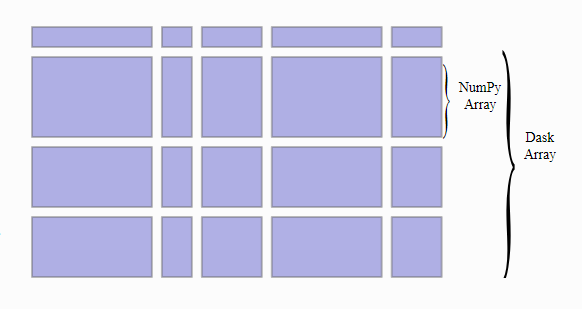

Known limitations:

- Not all linear algebra methods are supported.
- Sorting is terrible (this is a hard problem to solve in parallel systems).
- Most of what is being worked at the point in time of this session depends on need so there isn't a huge priority to lesser methods and the more obscure features of Numpy.

### 3. Reviewing the Dashboard

From experience, the Dask Dashboard is kind of touchy as a local cluster on a Windows machine.  Sometimes it will crash.  Other times it will stop responding to requests while Dask fundamentally works.  When it stops functioning, the best thing to do is to restart your kernel and/or notebook environment in these circumstances.  On Mac or Linux, the Dashboard seems a lot more consistent.

The prime reasons for using the Dashboard
- Used for diagnostics 
- Handy to have in context while you work in Jupyter
- Understand which types of operations account for your graph
- Diagnose resource problems from a macro or micro level

![](../media/dask_worker_run.gif)

### Generate Some Random Data

This is only a basic demo to get the diagnostics dashboard to come alive.

In [ ]:
a = da.random.random((10000, 10000, 10), chunks = (1000, 1000, 10))
b = da.random.random((10000, 10000, 10), chunks = (1000, 1000, 10))
c = (da.arcsin(a) + da.arccos(b)).sum(axis = (1, 2))

distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)




#### The Progress Bars (Right to Left)

- Each bar represents a task type and is coded by color.
- The colors matches the timeline of events for each **Worker Core** above.

**The solid grey color in the progress bar** represents tasks that are ready to run.  If there were more worker cores available, they would be able to run.
![](https://snipboard.io/TqbhJ4.jpg)

**The solid darker color close on the right side of the progress bar** is data actively used in memory.
![](https://snipboard.io/NZPE7x.jpg)

**The more translucent color the left on the progress bar** is data that was already processed and released from memory
![](https://snipboard.io/Dwpnec.jpg)

Generally, it's preferable that data doesn't get stuck in any one process too long and the window of memory per task moves consistently.

#### Memory Usage

![](https://snipboard.io/gnuxe2.jpg)

Each of the bands in the memory usage graph represents the memory used per each worker.  If you roll your mouse over each bar, it will tell you how much memory is being used for the worker in context.  The number above the graph is the aggregate memory used by all workers.


#### Tasks Processing

![](https://snipboard.io/xSd36k.jpg)

Each band is a worker on this graph just like memory usage.  The X-axis represents the number of tasks processing per worker.

### Another Reference Video of The Dashboard

In the event of a catastrophic dashboard crash, I'm leaving this here in case we need something tangible to look at.

In [ ]:
from IPython.display import Video

Video("../media/dask.mp4", width = 900)

### 4. Summary

#### 1. Tasks are represented within DAGs

- The flow of the DAG happens from the bottom up.
- The order of tasks is represented in the order they occur.
- Names of functions are drawn over the task objects.

![](https://snipboard.io/LAYNta.jpg)

> We used the `delayed` functionality, which enables the wrapping of existing Python functions into DAG tasks for parallelization.  This is useful for building custom graphs and adapting generic Python methods for Dask processing.

#### 2. Dask provides simple yet powerful collection types

#### Bag
- Distributed lists.
- Immutable type.
- Data is stored by partition.
- Similar to Spark's RDD.
- Has basic `map`, `filter`, and `groupby` functionality.

> **Great for:**
> - Preprocessing and preparing data.
> - Loading massive amounts of files stored in directories or buckets.
> - Can be converted to a Dask DataFrame, which is quite similar to a regular Pandas DataFrame.

#### Array
- Distributed Numpy
- Data also stored in partitions called "chunks" in a grid-like manner.
- Supports the best of class features of Numpy.
- Can do almost anything regular Numpy can do, but at scale.

> **Known limitations:**
>
> - Not all linear algebra methods are supported.
> - Sorting is terrible (this is a hard problem to solve in parallel systems).
> - Most of what is being worked at the point in time of this session depend on need, so there isn't a massive priority to lesser methods and the more obscure features of Numpy.


#### 3. Diagnostics Dashboard

- Works standalone through the `client` object or as a Jupyterlab extension (convenient).
- Can be buggy, especially on Windows.
- Used for diagnostics
- Handy to have in context while you work in Jupyter
- Understand which types of operations account for your graph
- Diagnose resource problems from a macro or micro level

